## Dataset Loading

In [1]:
# Load Dataset
import tensorflow as tf

# Balance
train_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/train'
val_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/val'
test_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/test'

# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)  # Image dimensions

# Load the train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   shuffle=False,
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMG_SIZE)

Found 9973 files belonging to 10 classes.
Found 1595 files belonging to 10 classes.
Found 1607 files belonging to 10 classes.


In [2]:
# Print class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [3]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to each dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [4]:
# Define input shape, number of classes and batch size
input_shape = (256, 256, 3)
num_classes = 10  
batch_size = 32

## Vision Transformer

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt

# Vision Transformer Parameters
image_size = 256  # Input image size
patch_size = 16  # Patch size
num_patches = (image_size // patch_size) ** 2  # Total patches
projection_dim = 64  # Dimension of the embedding space
num_heads = 4  # Number of attention heads
transformer_units = [projection_dim * 2, projection_dim]  # Feed-forward network units
num_transformer_blocks = 8  # Number of transformer blocks
mlp_head_units = 128  # Units in the final MLP head

# Helper classes for creating patches and encoding them
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [6]:
def build_vit_model(hp):
    patch_size = hp.Choice("patch_size", [16, 32])  # Avoid very small patches
    projection_dim = hp.Int("projection_dim", min_value=32, max_value=64, step=16)
    num_heads = hp.Int("num_heads", min_value=2, max_value=4, step=2)

    num_transformer_blocks = hp.Int("num_transformer_blocks", min_value=4, max_value=12, step=2)
    mlp_head_units = hp.Int("mlp_head_units", min_value=64, max_value=256, step=64)
    learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])

    inputs = layers.Input(shape=(256, 256, 3))
    patches = Patches(patch_size)(inputs)
    num_patches = (256 // patch_size) ** 2
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(num_transformer_blocks):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=projection_dim * 2, activation="relu")(x3)
        x3 = layers.Dense(units=projection_dim, activation="relu")(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dense(mlp_head_units, activation="relu")(representation)
    representation = layers.Dropout(0.5)(representation)
    logits = layers.Dense(10, activation="softmax")(representation)

    model = models.Model(inputs=inputs, outputs=logits)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Instantiate the Random Search tuner
tuner = kt.RandomSearch(
    build_vit_model,  # Model-building function
    objective="val_accuracy",  # Optimization objective
    max_trials=10,  # Number of random combinations to try
    executions_per_trial=1,  # Number of times to train each model configuration
    directory="vit_tuning",  # Directory to save tuning results
    project_name="vit_random_search",  # Project name for this tuning session
)

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Run the random search
tuner.search(
    train_dataset,  
    validation_data=val_dataset, 
    epochs=20,  # Number of epochs for each trial
    callbacks=[early_stopping],
)

Trial 10 Complete [00h 05m 08s]
val_accuracy: 0.9015673995018005

Best val_accuracy So Far: 0.9536049962043762
Total elapsed time: 00h 38m 15s


In [9]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best patch size: {best_hps.get('patch_size')}")
print(f"Best projection dimension: {best_hps.get('projection_dim')}")
print(f"Best number of heads: {best_hps.get('num_heads')}")
print(f"Best number of transformer blocks: {best_hps.get('num_transformer_blocks')}")
print(f"Best MLP head units: {best_hps.get('mlp_head_units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Best patch size: 16
Best projection dimension: 48
Best number of heads: 2
Best number of transformer blocks: 12
Best MLP head units: 128
Best learning rate: 0.001


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the best model
vit_model_tuning = tuner.hypermodel.build(best_hps)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = vit_model_tuning.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 122s 165ms/step - accuracy: 0.1406 - loss: 2.3077 - val_accuracy: 0.2508 - val_loss: 1.8708 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4112 - loss: 1.6307 - val_accuracy: 0.5818 - val_loss: 1.1959 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6063 - loss: 1.1150 - val_accuracy: 0.7492 - val_loss: 0.7447 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.7346 - loss: 0.7684 - val_accuracy: 0.7887 - val_loss: 0.6344 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8002 - loss: 0.5839 - val_accuracy: 0.8489 - val_loss: 0.4551 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8474 - loss: 0.4473 - val_accuracy: 0.8163 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8712 -

In [11]:
# Evaluate the model
test_loss, test_accuracy = vit_model_tuning.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9561 - loss: 0.1576
Test Accuracy: 0.9620410799980164


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = vit_model_tuning.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)  # Get the predicted class labels
true_classes = tf.concat([y for x, y in test_dataset], axis=0)  # True labels from the test dataset

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step
Precision: 0.9623936805555875
Recall: 0.9620410703173615
F1 Score: 0.9620634224379171


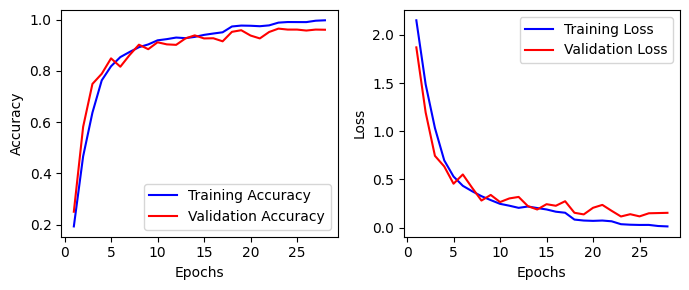

In [13]:
import matplotlib.pyplot as plt

# Retrieve model training and validation metrics from the history object
acc2 = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy
loss2 = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

# Define the range for epochs
epochs = range(1,len(acc2)+1)

# Plot training and validation accuracy on the first subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Plot training and validation accuracy on the first subplot
axes[0].plot(epochs, acc2, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss on the second subplot
axes[1].plot(epochs, loss2, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test dataset
y_pred = vit_model_tuning.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from test_dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate classification report with meaningful class names
report = classification_report(test_labels, y_pred_classes, target_names=class_names)
print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.95      0.94      0.95       214
                        Tomato_Early_blight       0.94      0.95      0.95       100
                         Tomato_Late_blight       0.97      0.95      0.96       191
                           Tomato_Leaf_Mold       0.94      0.99      0.96        96
                  Tomato_Septoria_leaf_spot       0.98      0.99      0.99       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.93      0.96      0.94       169
                        Tomato__Target_Spot       0.98      0.94      0.96       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.97      0.95      0.96       321
                Tomato__Tomato_mosaic_virus       0.93      1.00      0.96        38
                             Tomato_healthy       1.00      0.99      1.00       159

                       

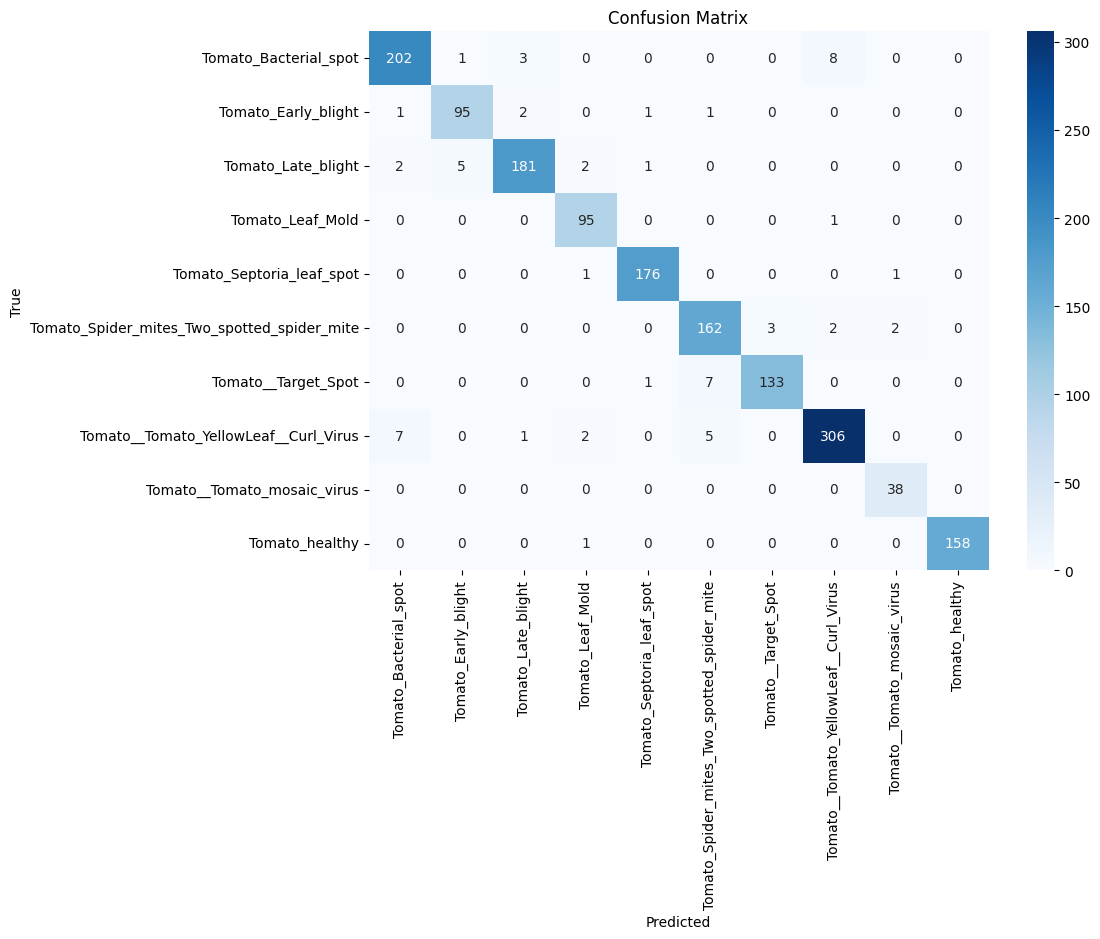

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()